In [1]:
#Imports
import numpy as np
from midiutil import MIDIFile
import matplotlib.pyplot as plt
import ternary
from ternary.helpers import simplex_iterator
import graphviz
import anytree as at
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
import theano.tensor as T
from theano import function
import theano

# helpers
import sys
sys.path.insert(0, 'helpers/')
from tree_parser import TreeParser
from midi import *

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# CONSTANTS
L = 8 # length of measure
N = int(np.log2(L)+1) # Number of levels (including 0)

In [3]:
# Initial THEANO symbolic variables

p1 = T.dscalar('p1')
p2 = T.dscalar('p2')
p3 = T.dscalar('p3')

In [4]:
# 2-ways dictionary, not too slow...
class bidict(dict):
    def __init__(self, *args, **kwargs):
        super(bidict, self).__init__(*args, **kwargs)
        self.inverse = {}
        for key, value in self.items():
            self.inverse.setdefault(value,[]).append(key) 

    def __setitem__(self, key, value):
        if key in self:
            self.inverse[self[key]].remove(key) 
        super(bidict, self).__setitem__(key, value)
        self.inverse.setdefault(value,[]).append(key)        

    def __delitem__(self, key):
        self.inverse.setdefault(self[key],[]).remove(key)
        if self[key] in self.inverse and not self.inverse[self[key]]: 
            del self.inverse[self[key]]
        super(bidict, self).__delitem__(key)

# Set of all trees, and probability of all trees

In [6]:
#With direct computation of the probs (very slow)


# Templates level 1
templates_1 = set()
templates_1.add(p2)
templates_1.add(p3)

tree_prob_1 = dict()
tree_prob_1[p2] = p2
tree_prob_1[p3] = p3

# Templates level 2
templates_2 = set()
templates_2.add(p2)
templates_2.add(p3)

tree_prob_2 = dict()
tree_prob_2[p2] = p2
tree_prob_2[p3] = p3

for elem1 in templates_1:
    for elem2 in templates_1:
        templates_2.add((elem1, elem2))      
        tree_prob_2[(elem1, elem2)] = p1*tree_prob_1[elem1]*tree_prob_1[elem2]

# Templates level 3
templates_3 = set()
templates_3.add(p2)
templates_3.add(p3)

tree_prob_3 = dict()
tree_prob_3[p2] = p2
tree_prob_3[p3] = p3

for elem1 in templates_2:
    for elem2 in templates_2:
        templates_3.add((elem1, elem2))
        tree_prob_3[(elem1, elem2)] = p1*tree_prob_2[elem1]*tree_prob_2[elem2]
        
# Templates level 4
templates_4 = set()
templates_4.add(p2)
templates_4.add(p3)

tree_prob_4 = dict()
tree_prob_4[p2] = p2
tree_prob_4[p3] = p3

for elem1 in templates_3:
    for elem2 in templates_3:
        templates_4.add((elem1, elem2))
        tree_prob_4[(elem1, elem2)] = p1*tree_prob_3[elem1]*tree_prob_3[elem2]
        
# Templates level 5
all_trees = set()
all_trees.add(p2)
all_trees.add(p3)

tree2prob = dict()
tree2prob[p2] = p2
tree2prob[p3] = p3

for elem1 in templates_3:
    for elem2 in templates_3:
        all_trees.add((elem1, elem2))
        tree2prob[(elem1, elem2)] = p1*tree_prob_3[elem1]*tree_prob_3[elem2]
        
len(tree2prob)

1446

# Set of all rhythms

In [7]:
all_rhythms = set()

for i in range(2**L): # populating
    all_rhythms.add( tuple(("{0:0%sb}" %L).format(i)) )
    
len(all_rhythms)

256

# 2-way dictionnary between trees and rhythms

In [8]:
def tree_to_rhythm(tree, size=L):    
    if(p2 == tree):
        tup = ('1',) + ('0',) * int(size-1)
        return tup    
    elif(p3 == tree):
        tup = ('0',) * int(size)
        return tup    
    else:
        return tree_to_rhythm(tree[0], size/2) + tree_to_rhythm(tree[1], size/2)
    
trees2rhythms = bidict() # initial bidirection dictionary (can't be stored with pickle.....)

for tree in all_trees:
    trees2rhythms[tree] = tree_to_rhythm(tree)
    
# 2 dict for the 2 directions 
rhythm2trees = trees2rhythms.inverse
tree2rhythm  = dict(trees2rhythms)

len(rhythm2trees)

256

# Probability of each rhythm (set)

In [9]:
rhythm2prob = {}

for rhythm in all_rhythms: 
    prob_rhythm = 0
    for tree in rhythm2trees[rhythm]:
        prob_rhythm += tree2prob[tree]
        
    rhythm2prob[rhythm] = prob_rhythm

#save
import pickle
with open('files/rhythm2prob.pickle', 'wb') as f:
    pickle.dump(rhythm2prob, f)
    

# Set of all templates, and probability of a template

In [36]:
# Templates level 1
templates_1 = set()
templates_1.add(p2)
templates_1.add(p3)
templates_1.add(tuple())

template_prob_1 = dict()
template_prob_1[p2] = p2
template_prob_1[p3] = p3
template_prob_1[tuple()] = p1

# Templates level 2
templates_2 = set()
templates_2.add(p2)
templates_2.add(p3)

template_prob_2 = dict()
template_prob_2[p2] = p2
template_prob_2[p3] = p3

for elem1 in templates_1:
    for elem2 in templates_1:
        templates_2.add((elem1, elem2))
        template_prob_2[(elem1, elem2)] = p1*template_prob_1[elem1]*template_prob_1[elem2]
        
# Templates level 3
all_templates = set()
all_templates.add(p2)
all_templates.add(p3)

template2prob = dict()
template2prob[p2] = p2
template2prob[p3] = p3

for elem1 in templates_2:
    for elem2 in templates_2:
        all_templates.add((elem1, elem2))
        template2prob[(elem1, elem2)] = p1*template_prob_2[elem1]*template_prob_2[elem2]
               
len(template2prob)

123

# 2-ways dict between templates and trees

In [11]:
def tree_to_template(tree, depth=0):
    if isinstance(tree, tuple) and depth<2:
        return (tree_to_template(tree[0], depth+1), tree_to_template(tree[1], depth+1))
    
    if isinstance(tree, tuple):
        return tuple()
    
    return tree

trees2templates = bidict() # initial bidirection dictionary (can't be stored with pickle.....)

for tree in all_trees:
    trees2templates[tree] = tree_to_template(tree)
    
# 2 dict for the 2 directions 
template2trees = trees2templates.inverse
tree2template  = dict(trees2templates)

# 2-ways dict betweem rhythms and templates

In [12]:
rhythm2templates = dict()

for rhythm in all_rhythms:
    temp_set = set()
    for tree in rhythm2trees[rhythm]:
        temp_set.add(tree2template[tree])
        
    rhythm2templates[rhythm] = temp_set

#-----------------------

template2rhythms = dict()

for template in all_templates:
    rhythm_set = set()
    for tree in template2trees[template]:
        rhythm_set.add(tree2rhythm[tree])
        
    template2rhythms[template] = rhythm_set
    
len(template2rhythms)

123

# Prob of a rhythm knowing its template

In [58]:
rhythm_template2prob = dict()

for template in all_templates:
    temp_prob = template2prob[template]
    for rhythm in template2rhythms[template]:
        connection_trees_prob=0
        for tree in template2trees[template]:
            if (tree in rhythm2trees[rhythm]):
                connection_trees_prob += tree2prob[tree]
                
        rhythm_template2prob[(rhythm, template)] = connection_trees_prob / temp_prob
              
len(rhythm_template2prob)

1446

# Dict template to its entropy

In [14]:
template2entropy = dict()

for template in all_templates:
    all_probs=list()
    for rhythm in template2rhythms[template]:
        all_probs.append( rhythm2prob[rhythm] )
                         
    template2entropy[template] = -T.sum(T.log2(all_probs) * all_probs)
    
#save
import pickle
with open('files/template2entropy.pickle', 'wb') as f:
    pickle.dump(template2entropy, f)
            
len(template2entropy)

123

# Dict template to its ENB

In [60]:
# Weigths for the ENB
weights = (1,) * L

def rhythm_to_NB(rhythm):
    NB = 0
    for i in range (len(rhythm)):
        if(rhythm[i]=='1'):
            NB+=weights[i]       
    return NB

template2ENB = dict()

for template in all_templates:
    ENB = 0
    for rhythm in template2rhythms[template]:
        ENB += rhythm_to_NB(rhythm) * rhythm_template2prob[(rhythm, template)]
        
    template2ENB[template] = ENB
    
len(template2ENB)

123

# Find pairs of similar templates with GD

In [279]:
step = 0.01
max_iter = 10000
cost = T.sqr( template2ENB[template1]-template2ENB[template2] ) + T.sqr( template2entropy[template1]-template2entropy[template2] ) + T.sqr( p1+p2+p3-1 )
gp1, gp2, gp3 = T.grad(cost, [p1, p2, p3]) # gradient computation
gp1_f, gp2_f, gp3_f = theano.function([p1, p2, p3], gp1), theano.function([p1, p2, p3], gp2), theano.function([p1, p2, p3], gp3)

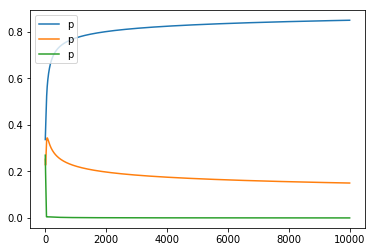

In [280]:
p1_num = 1/3 # arbitrary initial values
p2_num = 1/3
p3_num = 1/3

GD = list()
for i in range(max_iter):
    p1_num, p2_num, p3_num = np.clip(p1_num - step * gp1_f(p1_num, p2_num, p3_num), 0, 1),  np.clip(p2_num - step * gp2_f(p1_num, p2_num, p3_num), 0, 1),  np.clip(p3_num - step * gp3_f(p1_num, p2_num, p3_num), 0, 1)
    GD.append((p1_num, p2_num, p3_num))

plt.plot(GD, label="p")
plt.legend(loc='upper left')
plt.show()

In [281]:
p1_num, p2_num, p3_num

(0.8492080390720381, 0.15022146457579397, 0.00044237482835659625)

In [285]:
template2

(p3, p3)